In [1]:
import os
import numpy as np 
import matplotlib.pyplot as plt


classes = ['airplane', 'bench', 'cabinet', 'car', 'chair', 'display', 'lamp', 'loudspeaker', 'rifle', 'sofa', 'table', 'telephone', 'vessel']


airplane lowest test loss = 0.287
airplane lowest train loss = 0.294


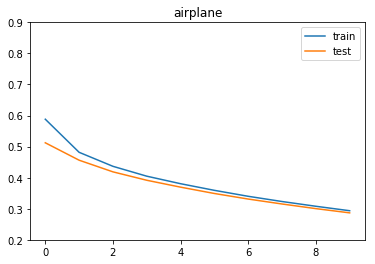

bench lowest test loss = 0.304
bench lowest train loss = 0.307


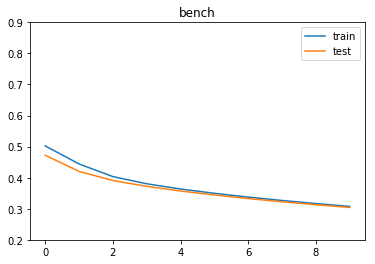

cabinet lowest test loss = 0.515
cabinet lowest train loss = 0.523


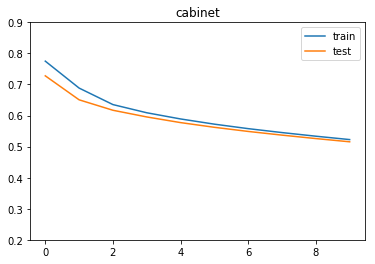

car lowest test loss = 0.239
car lowest train loss = 0.247


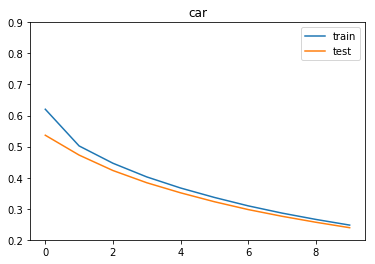

chair lowest test loss = 0.207
chair lowest train loss = 0.212


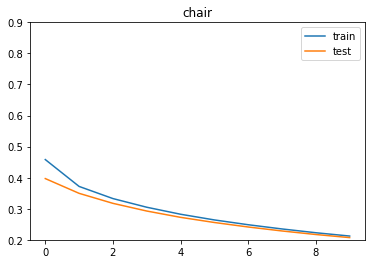

display lowest test loss = 0.432
display lowest train loss = 0.437


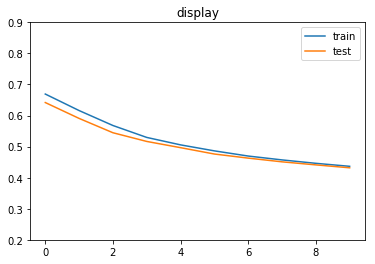

lamp lowest test loss = 0.401
lamp lowest train loss = 0.407


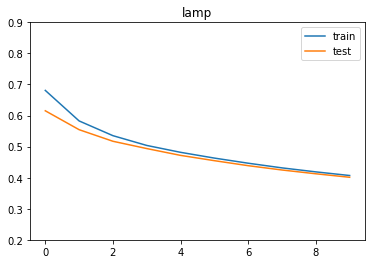

loudspeaker lowest test loss = 0.546
loudspeaker lowest train loss = 0.555


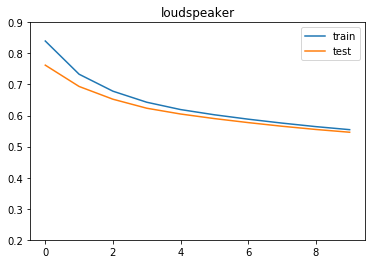

rifle lowest test loss = 0.407
rifle lowest train loss = 0.416


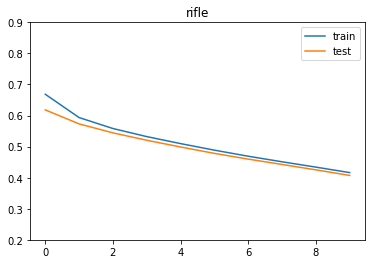

sofa lowest test loss = 0.348
sofa lowest train loss = 0.351


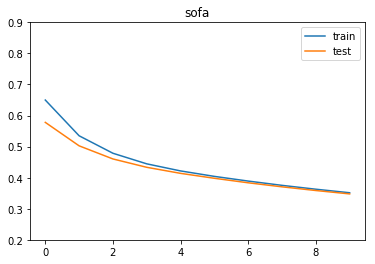

table lowest test loss = 0.231
table lowest train loss = 0.237


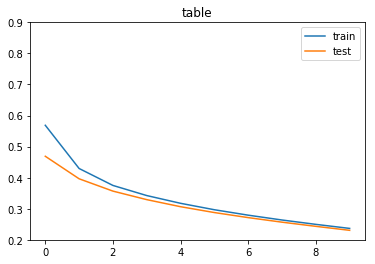

telephone lowest test loss = 0.358
telephone lowest train loss = 0.362


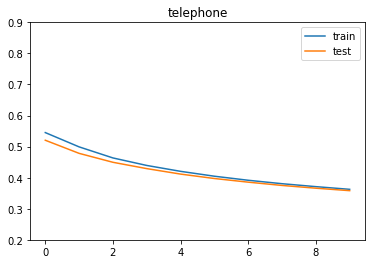

vessel lowest test loss = 0.292
vessel lowest train loss = 0.297


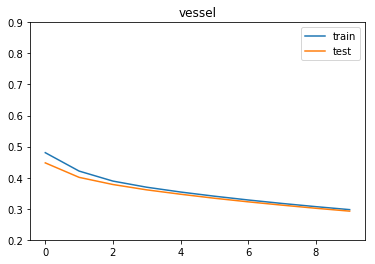

All classes lowest test loss = ves
All classes lowest train loss = ves


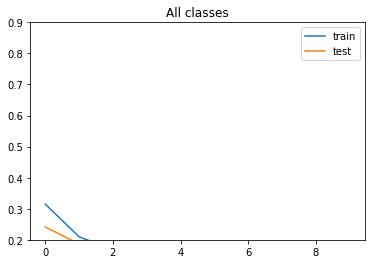

In [46]:
for c in classes: 
    l = np.load('checkpoints/experiment_{}/losses.npy'.format(c))
    print('{} lowest test loss = {:.3}'.format(c,np.min(l[1])))
    print('{} lowest train loss = {:.3}'.format(c,np.min(l[0])))
    
    plt.figure()
    plt.plot(l[0], label='train')
    plt.plot(l[1], label='test')
    plt.legend()
    plt.ylim(0.2,0.9)
    plt.title('{}'.format(c))
    plt.show()

l = np.load('checkpoints/experiment_1584465573/losses.npy'.format(c))
print('All classes lowest test loss = {:.3}'.format(np.min(l[1])))
print('All classes lowest train loss = {:.3}'.format(np.min(l[0])))

plt.figure()
plt.plot(l[0], label='train')
plt.plot(l[1], label='test')
plt.legend()
plt.ylim(0.2,0.9)
plt.title('All classes')
plt.show()


In [26]:
import torch 

from config import SHAPENET_IM, SHAPENET_VOX
from shapenet_pytorch import ShapeNetDataset
from lsm import LSM

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

nvox = 32
batch_size = 20
nviews = 4

### DATALOADING
vox_dir = SHAPENET_VOX[nvox]
im_dir = SHAPENET_IM
split_file = './splits.json'

#{'airplane': '02691156', 'bench': '02828884', 'cabinet': '02933112', 'car': '02958343', 'chair': '03001627', 'display': '03211117', 'lamp': '03636649', 'loudspeaker': '03691459', 'rifle': '04090263', 'sofa': '04256520', 'table': '04379243', 'telephone': '04401088', 'vessel': '04530566'}



def iou(vox_pred, vox): 
    vox_pred[vox_pred > 0.4] = 1
    vox_pred = vox_pred.type(torch.IntTensor)
    vox = vox.type(torch.IntTensor)
    intersection = (vox_pred & vox).sum((1,2))
    union = (vox_pred | vox).sum((1,2))
    
    return (intersection + 1e-6) / (union + 1e-6)

def test(test_batch_loader, lsm):
    running_iou = 0.0
    with torch.no_grad():
        for i, batch in enumerate(test_batch_loader):
            imgs, vox, K, R = batch
            imgs = imgs.type(torch.FloatTensor).to(device)
            vox = vox.type(torch.FloatTensor).to(device)
            K = K.type(torch.FloatTensor).to(device)
            R = R.type(torch.FloatTensor).to(device)
            K = K.view(-1, 3, 3)
            R = R.view(-1, 3, 4)

            vox_pred = lsm(imgs, K, R)
            #loss = loss_func(vox_pred, vox)
            #running_loss += loss.item()
            iou_batch = iou(vox_pred, vox).mean()
            running_iou += iou_batch.item()

    return running_iou/len(test_batch_loader)

In [44]:
for c in classes: 
    
    lsm = LSM(device)

    
    categories = [c]

    test_dataset = ShapeNetDataset(im_dir, vox_dir, nviews, nvox, split_file, train=False, categories=categories)
    test_batch_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)
    
    sd = torch.load('checkpoints/experiment_{}/best_model.pth'.format(c))
    if 'image_enc.conv_bn1.running_var' in sd.keys(): 
        lsm.load_state_dict(sd)
        lsm.eval()
        iou_test = test(test_batch_loader, lsm)
        print("{} test iou = {}".format(c, iou_test))
    else: 
        print("bn model missing for {}".format(c))

airplane test iou = 0.9253470577844759
bench test iou = 0.7629006755979437
cabinet test iou = 0.31523851677775383
car test iou = 0.9395936978490729
chair test iou = 0.7582416692200828
display test iou = 0.3459341363473372
lamp test iou = 0.4821453367670377
loudspeaker test iou = 0.24678208722787745
rifle test iou = 0.6932259698708853
bn model missing for sofa
table test iou = 0.8326365809107936
telephone test iou = 0.6012720682404258
vessel test iou = 0.9343764454126358


In [45]:
test_dataset = ShapeNetDataset(im_dir, vox_dir, nviews, nvox, split_file, train=False, categories=None)
test_batch_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)
lsm = LSM(device)  
sd = torch.load('checkpoints/experiment_1584465573/best_model.pth')
lsm.load_state_dict(sd)
lsm.eval()
iou_test = test(test_batch_loader, lsm)
print("{} test iou = {}".format(c, iou_test))

vessel test iou = 0.8126737881358501
